In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pylab
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from pyod.models.knn import KNN
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
df=pd.read_excel('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Квартиры Киров/Квартиры_Киров_выбока_2.xlsx', sheet_name = 0)
df.head()

,Комнатность,LN(Общая площадь),Общая площадь,Площадь кухни,Жилая площадь,Этаж 1,Этаж 2,Этажей в доме,Ремонт,Материал стен,...,последний,средний,деревянный,кирпичный,монолитный,панельный,дизайнерский,евро,косметический,требует ремонта
0,2к,3.799974,44.7,5.900000,29.458690,5,последний,5,евро,панельный,...,1,0,0,0,0,1,0,1,0,0
1,1к,3.465736,32.0,6.900000,17.655975,2,средний,5,косметический,кирпичный,...,0,1,0,1,0,0,0,0,1,0
2,студия,3.502550,33.2,6.633333,18.193506,3,последний,3,евро,кирпичный,...,1,0,0,1,0,0,0,1,0,0
3,2к,3.943522,51.6,8.800000,28.744021,6,средний,7,евро,кирпичный,...,0,1,0,1,0,0,0,1,0,0
4,3к,3.998201,54.5,18.000000,27.597229,18,средний,19,дизайнерский,панельный,...,0,1,0,0,0,1,1,0,0,0


1. Выборка 1 - без исключения выбросов (с учетом нормализации и стандартизации).
2. Выборка 2 - исключение экстремальных выбросов.
3. Выборка 3 - исключение выбросов по общей площади и цене.
4. Выборка 4 - исключение выбросов по логарифмированным общей площади и цене.
5. Выборка 5 - исключение выбросов алгоритмом KNN.

<font size = 3><div style="text-align: justify">**Выборка 1:**</div></font>

In [162]:
df_v1 = df.copy()
len(df_v1)

2399

In [55]:
#X = df_v1[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v1[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v1['Цена']
Y = df_v1['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [8]:
#RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['log2', 'sqrt', 'auto']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfr = RandomForestRegressor()

rs = RandomizedSearchCV(rfr, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

rs.fit(X_train, Y_train)

rs.best_params_ # параметры лучшей модели

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 70,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 7,
 'bootstrap': True}

In [9]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,70,2,2,auto,7,True,0.856277,1
1,60,18,7,sqrt,10,False,0.845903,2
2,100,28,12,auto,15,True,0.834186,3
3,10,18,12,auto,11,True,0.832723,4
4,40,18,7,sqrt,14,True,0.832070,5
5,100,44,2,auto,6,True,0.829258,6
6,30,7,12,log2,14,False,0.821570,7
7,80,18,12,sqrt,13,True,0.810246,8
8,20,23,2,auto,12,False,0.809017,9
9,20,23,7,auto,15,False,0.807467,10


Text(0, 0.5, 'mean_test_score')

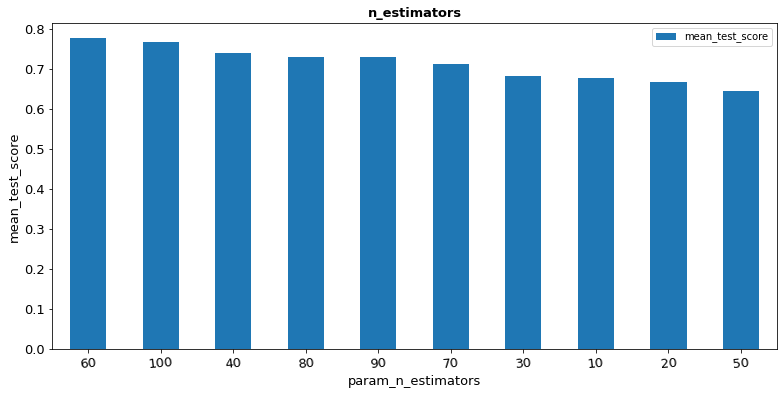

In [15]:
# Столбиковая диаграмма
y = rs_df[['param_n_estimators', 'mean_test_score']].groupby('param_n_estimators').mean().sort_values('mean_test_score', ascending=False)
y.plot(kind="bar", rot=5, fontsize=13, figsize=(13,6))
plt.title('n_estimators', fontsize=13, fontweight='bold')
plt.xlabel('param_n_estimators', fontsize=13)
plt.ylabel('mean_test_score', fontsize=13)

Text(0, 0.5, 'mean_test_score')

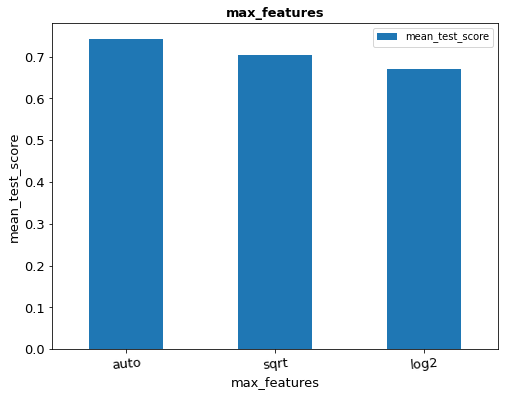

In [18]:
# Столбиковая диаграмма
y = rs_df[['param_max_features', 'mean_test_score']].groupby('param_max_features').mean().sort_values('mean_test_score', ascending=False)
y.plot(kind="bar", rot=5, fontsize=13, figsize=(8,6))
plt.title('max_features', fontsize=13, fontweight='bold')
plt.xlabel('max_features', fontsize=13)
plt.ylabel('mean_test_score', fontsize=13)

Text(0, 0.5, 'mean_test_score')

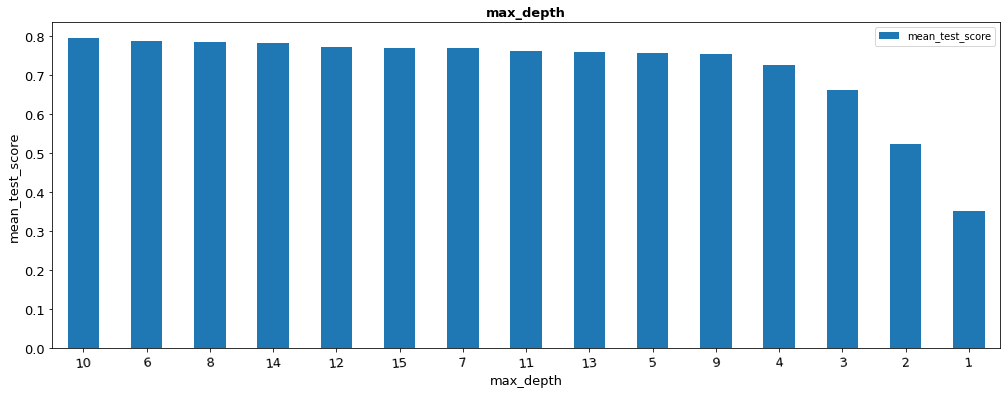

In [19]:
# Столбиковая диаграмма
y = rs_df[['param_max_depth', 'mean_test_score']].groupby('param_max_depth').mean().sort_values('mean_test_score', ascending=False)
y.plot(kind="bar", rot=5, fontsize=13, figsize=(17,6))
plt.title('max_depth', fontsize=13, fontweight='bold')
plt.xlabel('max_depth', fontsize=13)
plt.ylabel('mean_test_score', fontsize=13)

Text(0, 0.5, 'mean_test_score')

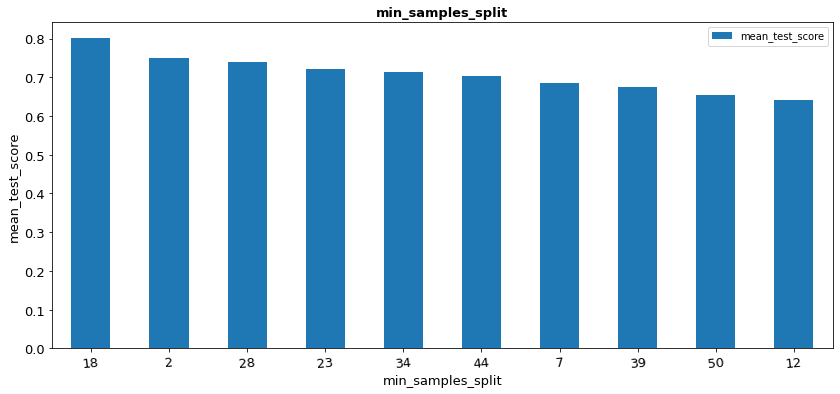

In [21]:
# Столбиковая диаграмма
y = rs_df[['param_min_samples_split', 'mean_test_score']].groupby('param_min_samples_split').mean().sort_values('mean_test_score', ascending=False)
y.plot(kind="bar", rot=5, fontsize=13, figsize=(14,6))
plt.title('min_samples_split', fontsize=13, fontweight='bold')
plt.xlabel('min_samples_split', fontsize=13)
plt.ylabel('mean_test_score', fontsize=13)

Text(0, 0.5, 'mean_test_score')

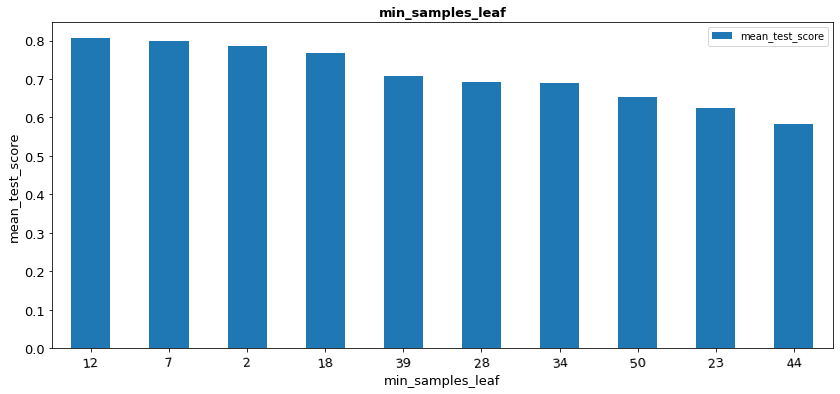

In [22]:
# Столбиковая диаграмма
y = rs_df[['param_min_samples_leaf', 'mean_test_score']].groupby('param_min_samples_leaf').mean().sort_values('mean_test_score', ascending=False)
y.plot(kind="bar", rot=5, fontsize=13, figsize=(14,6))
plt.title('min_samples_leaf', fontsize=13, fontweight='bold')
plt.xlabel('min_samples_leaf', fontsize=13)
plt.ylabel('mean_test_score', fontsize=13)

                 mean_test_score
param_bootstrap                 
True                    0.708189
False                   0.707305


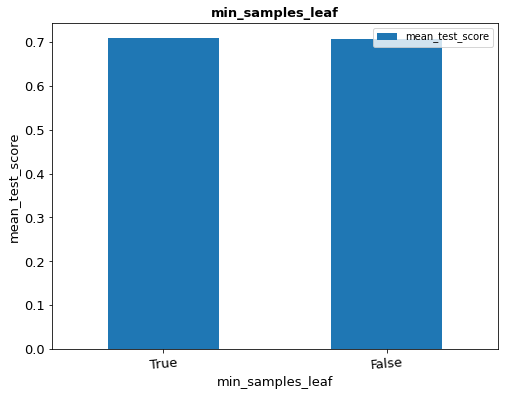

In [25]:
# Столбиковая диаграмма
y = rs_df[['param_bootstrap', 'mean_test_score']].groupby('param_bootstrap').mean().sort_values('mean_test_score', ascending=False)
y.plot(kind="bar", rot=5, fontsize=13, figsize=(8,6))
plt.title('min_samples_leaf', fontsize=13, fontweight='bold')
plt.xlabel('min_samples_leaf', fontsize=13)
plt.ylabel('mean_test_score', fontsize=13)
print(y)

In [26]:
n_estimators = [40,60,80,90,100]
max_features = ['auto']
max_depth = [6,7,8,10,12,14,15]
min_samples_split = [2,18,23,28,34,44]
min_samples_leaf = [2,7,12,18]
bootstrap = [False, True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gs = GridSearchCV(rfr, 
                  param_grid, 
                  cv = 3, 
                  verbose = 1, 
                  n_jobs=-1)

gs.fit(X_train, Y_train)
#gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [56]:
rfr = RandomForestRegressor(n_estimators = 100, # n_estimators определяет количество деревьев в случайном лесу
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'auto',
                            #criterion = 'mae',
                            max_depth = 4,
                            bootstrap = True, 
                            random_state = 0)
rfr.fit(X_train, Y_train)

pred_train = rfr.predict(X_train)
pred_test = rfr.predict(X_test)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')

print(f'MAE train: {mae(Y_train, pred_train):.3f}')
print(f'MAE test: {mae(Y_test, pred_test):.3f}')

Train R2 0.822
Test R2 0.794
MAE train: 0.167
MAE test: 0.177


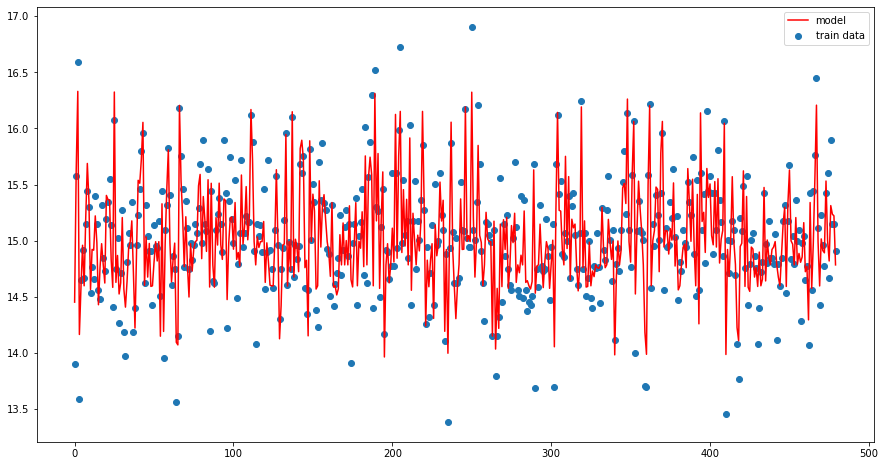

In [44]:
plt.figure(figsize=(15, 8))
plt.plot(range(len(Y_test)), pred_test, c='r', label='model');
plt.scatter(range(len(Y_test)), Y_test, label='train data')
plt.legend();

In [45]:
cv_score = cross_val_score(rfr, X_train, Y_train, cv = 5)
print("CV mean score:", cv_score.mean())

CV mean score: 0.7920131184036387


In [57]:
feature_importances = pd.DataFrame({'features': X.columns, 'feature_importance': rfr.feature_importances_})
print(feature_importances.sort_values('feature_importance', ascending=False))

                   features  feature_importance
0         LN(Общая площадь)            0.725057
5   Хронологический возраст            0.181223
4             Этажей в доме            0.070160
1             Площадь кухни            0.005780
7                    Широта            0.005508
6                   Долгота            0.003575
21             дизайнерский            0.002221
17               деревянный            0.002067
2             Жилая площадь            0.001987
24          требует ремонта            0.000917
3                    Этаж 1            0.000445
20                панельный            0.000304
18                кирпичный            0.000253
22                     евро            0.000179
23            косметический            0.000150
15                последний            0.000071
12               4к и более            0.000062
14                   первый            0.000020
8             Тип санузла 2            0.000014
16                  средний            0

In [65]:
X = df_v1[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
#X = df_v1[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v1['Цена']
Y = df_v1['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [66]:
rfr = RandomForestRegressor(n_estimators = 100, # n_estimators определяет количество деревьев в случайном лесу
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'auto',
                            #criterion = 'mae',
                            max_depth = 4,
                            bootstrap = True, 
                            random_state = 0)
rfr.fit(X_train, Y_train)

pred_train = rfr.predict(X_train)
pred_test = rfr.predict(X_test)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')

print(f'MAE train: {mae(Y_train, pred_train):.3f}')
print(f'MAE test: {mae(Y_test, pred_test):.3f}')

Train R2 0.822
Test R2 0.794
MAE train: 0.167
MAE test: 0.177


In [163]:
#X = df_v1[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v1[['LN(Общая площадь)', 'Площадь кухни', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#X = df_v1[['LN(Общая площадь)', 'Хронологический возраст']]

#Y = df_v1['Цена']
Y = df_v1['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [164]:
rfr = RandomForestRegressor(n_estimators = 150, # n_estimators определяет количество деревьев в случайном лесу
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'auto',
                            #criterion = 'mae',
                            max_depth = 4,
                            bootstrap = True, 
                            random_state = 0)
rfr.fit(X_train, Y_train)

pred_train = rfr.predict(X_train)
pred_test = rfr.predict(X_test)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')

print(f'MAE train: {mae(Y_train, pred_train):.3f}')
print(f'MAE test: {mae(Y_test, pred_test):.3f}')

Train R2 0.822
Test R2 0.796
MAE train: 0.167
MAE test: 0.177


In [165]:
feature_importances = pd.DataFrame({'features': X.columns, 'feature_importance': rfr.feature_importances_})
print(feature_importances.sort_values('feature_importance', ascending=False))

                  features  feature_importance
0        LN(Общая площадь)            0.727698
3  Хронологический возраст            0.182430
2            Этажей в доме            0.071052
1            Площадь кухни            0.006489
5                   Широта            0.005273
4                  Долгота            0.003706
6             дизайнерский            0.002088
9          требует ремонта            0.000910
8            косметический            0.000217
7                     евро            0.000137


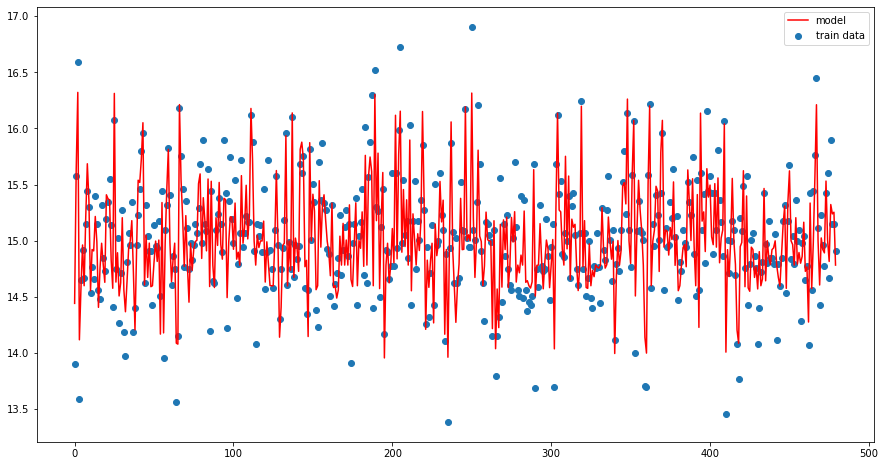

In [166]:
plt.figure(figsize=(15, 8))
plt.plot(range(len(Y_test)), pred_test, c='r', label='model');
plt.scatter(range(len(Y_test)), Y_test, label='train data')
plt.legend();

In [167]:
cv_score = cross_val_score(rfr, X_train, Y_train, cv = 5)
print("CV mean score:", cv_score.mean())

CV mean score: 0.7930803272399904


In [114]:
#X = df_v1[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v1[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v1['Цена']
Y = df_v1['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [115]:
mms_1 = MinMaxScaler()
mms_1.fit(X_train)

MinMaxScaler()

In [116]:
X_train_norm = pd.DataFrame(mms_1.transform(X_train), columns = X_train.columns)
X_train_norm

,LN(Общая площадь),Площадь кухни,Жилая площадь,Этаж 1,Этажей в доме,Хронологический возраст,Долгота,Широта,Тип санузла 2,1к,...,последний,средний,деревянный,кирпичный,монолитный,панельный,дизайнерский,евро,косметический,требует ремонта
0,0.321601,0.120339,0.144114,0.208333,0.192308,0.008130,0.463000,0.521013,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.393474,0.162712,0.159212,0.333333,0.576923,0.056911,0.641526,0.460025,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.327579,0.118644,0.146658,0.625000,0.576923,0.048780,0.728879,0.970162,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.595217,0.101695,0.540900,0.166667,0.346154,0.276423,0.527209,0.652693,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.297608,0.067797,0.165300,0.083333,0.307692,0.341463,0.600084,0.695905,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,0.399067,0.067797,0.258771,0.000000,0.153846,0.504065,0.604217,0.496566,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1915,0.463523,0.118644,0.302902,0.375000,0.346154,0.097561,0.719383,0.536968,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1916,0.165915,0.084746,0.085182,0.250000,0.307692,0.276423,0.679742,0.712538,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1917,0.592608,0.179661,0.512270,0.375000,0.615385,0.081301,0.637688,0.440757,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [117]:
X_test_norm = pd.DataFrame(mms_1.transform(X_test), columns = X_test.columns)
X_test_norm

,LN(Общая площадь),Площадь кухни,Жилая площадь,Этаж 1,Этажей в доме,Хронологический возраст,Долгота,Широта,Тип санузла 2,1к,...,последний,средний,деревянный,кирпичный,монолитный,панельный,дизайнерский,евро,косметический,требует ремонта
0,0.252376,0.080791,0.126077,0.041667,0.153846,0.284553,0.220679,0.186167,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.585100,0.254237,0.453133,0.375000,0.576923,0.016260,0.723854,0.992121,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.813787,0.203390,0.997466,0.125000,0.153846,0.178862,0.731906,0.676964,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.417544,0.067797,0.298428,0.041667,0.038462,0.479675,0.216504,0.193231,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.301910,0.067797,0.165883,0.125000,0.153846,0.414634,0.564576,0.654022,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.435734,0.084746,0.311011,0.041667,0.153846,0.439024,0.636719,0.539915,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
476,0.683416,0.120339,0.801611,0.083333,0.115385,0.235772,0.711432,0.605058,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
477,0.565773,0.118644,0.478251,0.000000,0.307692,0.268293,0.717010,0.700465,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
478,0.800712,0.172881,0.994828,0.000000,0.038462,0.707317,0.665381,0.774159,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [118]:
rfr = RandomForestRegressor(n_estimators = 150, # n_estimators определяет количество деревьев в случайном лесу
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'auto',
                            #criterion = 'mae',
                            max_depth = 4,
                            bootstrap = True, 
                            random_state = 0)
rfr.fit(X_train_norm, Y_train)

pred_train = rfr.predict(X_train_norm)
pred_test = rfr.predict(X_test_norm)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')

print(f'MAE train: {mae(Y_train, pred_train):.3f}')
print(f'MAE test: {mae(Y_test, pred_test):.3f}')

Train R2 0.823
Test R2 0.795
MAE train: 0.167
MAE test: 0.176


In [119]:
#X = df_v1[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v1[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v1['Цена']
Y = df_v1['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [120]:
mms_2 = StandardScaler()
mms_2.fit(X_train)

StandardScaler()

In [121]:
X_train_std = pd.DataFrame(mms_2.transform(X_train), columns = X_train.columns)
X_train_std

,LN(Общая площадь),Площадь кухни,Жилая площадь,Этаж 1,Этажей в доме,Хронологический возраст,Долгота,Широта,Тип санузла 2,1к,...,последний,средний,деревянный,кирпичный,монолитный,панельный,дизайнерский,евро,косметический,требует ремонта
0,-0.855906,-0.083902,-0.897183,0.181929,-0.603916,-1.163387,-1.644071,-0.259628,0.858284,1.583738,...,2.09534,-1.410353,-0.112538,0.737459,-0.254809,-0.621740,-0.283757,-0.663845,1.149102,-0.482181
1,-0.310568,0.367422,-0.810000,0.915378,1.285106,-0.881412,0.029550,-0.572831,0.858284,1.583738,...,-0.47725,0.709042,-0.112538,-1.356008,-0.254809,1.608389,-0.283757,-0.663845,1.149102,-0.482181
2,-0.810547,-0.101955,-0.882496,2.626759,1.285106,-0.928408,0.848453,2.046995,0.858284,1.583738,...,2.09534,-1.410353,-0.112538,-1.356008,-0.254809,1.608389,-0.283757,-0.663845,1.149102,-0.482181
3,1.220175,-0.282485,1.394106,-0.062554,0.151693,0.387477,-1.042130,0.416620,-1.165115,-0.631417,...,-0.47725,0.709042,-0.112538,0.737459,-0.254809,-0.621740,-0.283757,-0.663845,1.149102,-0.482181
4,-1.037953,-0.643544,-0.774844,-0.551520,-0.037210,0.763444,-0.358958,0.638536,0.858284,1.583738,...,-0.47725,0.709042,-0.112538,0.737459,-0.254809,-0.621740,-0.283757,-0.663845,1.149102,-0.482181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,-0.268129,-0.643544,-0.235083,-1.040486,-0.792818,1.703362,-0.320211,-0.385173,0.858284,-0.631417,...,-0.47725,-1.410353,-0.112538,0.737459,-0.254809,-0.621740,-0.283757,-0.663845,1.149102,-0.482181
1915,0.220938,-0.101955,0.019756,1.159861,0.151693,-0.646432,0.759439,-0.177691,-1.165115,-0.631417,...,2.09534,-1.410353,-0.112538,-1.356008,-0.254809,1.608389,-0.283757,1.506375,-0.870245,-0.482181
1916,-2.037190,-0.463014,-1.237493,0.426412,-0.037210,0.387477,0.387816,0.723955,0.858284,1.583738,...,-0.47725,0.709042,-0.112538,0.737459,-0.254809,-0.621740,-0.283757,-0.663845,1.149102,-0.482181
1917,1.200381,0.547951,1.228780,1.159861,1.474008,-0.740424,-0.006431,-0.671785,-1.165115,-0.631417,...,-0.47725,0.709042,-0.112538,-1.356008,-0.254809,1.608389,-0.283757,1.506375,-0.870245,-0.482181


In [122]:
X_test_std = pd.DataFrame(mms_2.transform(X_test), columns = X_test.columns)
X_test_std

,LN(Общая площадь),Площадь кухни,Жилая площадь,Этаж 1,Этажей в доме,Хронологический возраст,Долгота,Широта,Тип санузла 2,1к,...,последний,средний,деревянный,кирпичный,монолитный,панельный,дизайнерский,евро,косметический,требует ремонта
0,-1.381153,-0.505138,-1.001341,-0.796003,-0.792818,0.434473,-3.915752,-1.979241,0.858284,-0.631417,...,-0.47725,0.709042,-0.112538,-1.356008,-0.254809,1.608389,-0.283757,1.506375,-0.870245,-0.482181
1,1.143417,1.342281,0.887287,1.159861,1.285106,-1.116391,0.801345,2.159764,-1.165115,-0.631417,...,-0.47725,0.709042,-0.112538,-1.356008,-0.254809,1.608389,-0.283757,1.506375,-0.870245,-0.482181
2,2.878595,0.800692,4.030604,-0.307037,-0.792818,-0.176473,0.876837,0.541267,-1.165115,-0.631417,...,-0.47725,0.709042,-0.112538,-1.356008,3.924501,-0.621740,3.524143,-0.663845,-0.870245,-0.482181
3,-0.127935,-0.643544,-0.006080,-0.796003,-1.359525,1.562375,-3.954892,-1.942962,0.858284,-0.631417,...,2.09534,-1.410353,-0.112538,0.737459,-0.254809,-0.621740,-0.283757,-0.663845,-0.870245,2.073911
4,-1.005311,-0.643544,-0.771476,-0.307037,-0.792818,1.186407,-0.691833,0.423444,0.858284,1.583738,...,-0.47725,0.709042,-0.112538,0.737459,-0.254809,-0.621740,-0.283757,-0.663845,1.149102,-0.482181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.010087,-0.463014,0.066587,-0.796003,-0.792818,1.327395,-0.015514,-0.162556,0.858284,-0.631417,...,-0.47725,0.709042,-0.112538,-1.356008,-0.254809,1.608389,-0.283757,-0.663845,1.149102,-0.482181
476,1.889396,-0.083902,2.899615,-0.551520,-0.981720,0.152498,0.684895,0.171988,-1.165115,-0.631417,...,-0.47725,0.709042,-0.112538,0.737459,-0.254809,-0.621740,-0.283757,-0.663845,1.149102,-0.482181
477,0.996765,-0.101955,1.032331,-1.040486,-0.037210,0.340481,0.737185,0.661954,0.858284,-0.631417,...,-0.47725,-1.410353,-0.112538,0.737459,-0.254809,-0.621740,-0.283757,-0.663845,-0.870245,2.073911
478,2.779389,0.475739,4.015375,-1.040486,-1.359525,2.878259,0.253180,1.040415,-1.165115,-0.631417,...,-0.47725,-1.410353,-0.112538,0.737459,-0.254809,-0.621740,-0.283757,-0.663845,-0.870245,2.073911


In [128]:
rfr = RandomForestRegressor(n_estimators = 150, # n_estimators определяет количество деревьев в случайном лесу
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'auto',
                            #criterion = 'mae',
                            max_depth = 4,
                            bootstrap = True, 
                            random_state = 0)
rfr.fit(X_train_std, Y_train)

pred_train = rfr.predict(X_train_std)
pred_test = rfr.predict(X_test_std)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')

print(f'MAE train: {mae(Y_train, pred_train):.3f}')
print(f'MAE test: {mae(Y_test, pred_test):.3f}')

Train R2 0.823
Test R2 0.795
MAE train: 0.167
MAE test: 0.176


<font size = 3><div style="text-align: justify">**Вывод по выборке 1:**</div></font>

Хорошее качество наблюдается на первоначальной выборке с логарифмированной ценой и логарифмированной общей площадью. Отмечаю, что качество не изменяется при использовании нормализации и стандартизации. При исключении незначимых факторов качество не становится лучше.

<font size = 3><div style="text-align: justify">**Выборка 2:**</div></font>

In [129]:
df_v2 = df.copy()
len(df_v2)

2399

In [131]:
df_v2 = df.loc[df['Общая площадь'] < 175]
df_v2 = df_v2.loc[df_v2['Площадь кухни'] < 45]
df_v2 = df_v2.loc[df_v2['Жилая площадь'] < 80]
df_v2 = df_v2.loc[df_v2['Хронологический возраст'] < 100]
df_v2 = df_v2.loc[df_v2['Цена'] < 14800000]
len(df_v2)

2367

In [132]:
#X = df_v2[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v2[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v2['Цена']
Y = df_v2['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [145]:
rfr = RandomForestRegressor(n_estimators = 100, # n_estimators определяет количество деревьев в случайном лесу
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'auto',
                            #criterion = 'mae',
                            max_depth = 4,
                            bootstrap = True, 
                            random_state = 0)
rfr.fit(X_train, Y_train)

pred_train = rfr.predict(X_train)
pred_test = rfr.predict(X_test)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')

print(f'MAE train: {mae(Y_train, pred_train):.3f}')
print(f'MAE test: {mae(Y_test, pred_test):.3f}')

Train R2 0.814
Test R2 0.781
MAE train: 0.165
MAE test: 0.178


In [150]:
#X = df_v2[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v2[['LN(Общая площадь)', 'Площадь кухни', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#X = df_v2[['LN(Общая площадь)', 'Хронологический возраст']]

#Y = df_v2['Цена']
Y = df_v2['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [151]:
rfr = RandomForestRegressor(n_estimators = 100, # n_estimators определяет количество деревьев в случайном лесу
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'auto',
                            #criterion = 'mae',
                            max_depth = 4,
                            bootstrap = True, 
                            random_state = 0)
rfr.fit(X_train, Y_train)

pred_train = rfr.predict(X_train)
pred_test = rfr.predict(X_test)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')

print(f'MAE train: {mae(Y_train, pred_train):.3f}')
print(f'MAE test: {mae(Y_test, pred_test):.3f}')

Train R2 0.813
Test R2 0.783
MAE train: 0.165
MAE test: 0.178


<font size = 3><div style="text-align: justify">**Вывод по выборке 2:**</div></font>

Исключение экстремальных выбросов из данных не привело к улучшению модели.

<font size = 3><div style="text-align: justify">**Выборка 3:**</div></font>

In [152]:
df_v3 = df.copy()
len(df_v3)

2399

In [153]:
df_v3 = df.loc[df['Общая площадь'] < 90]
df_v3 = df_v3.loc[df_v3['Хронологический возраст'] < 100]
df_v3 = df_v3.loc[df_v3['Цена'] < 6000000]
df_v3 = df_v3.loc[df_v3['Площадь кухни'] < 30]
len(df_v3)

2075

In [154]:
#X = df_v3[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v3[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v3['Цена']
Y = df_v3['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [159]:
rfr = RandomForestRegressor(n_estimators = 100, # n_estimators определяет количество деревьев в случайном лесу
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'auto',
                            #criterion = 'mae',
                            max_depth = 5,
                            bootstrap = True, 
                            random_state = 0)
rfr.fit(X_train, Y_train)

pred_train = rfr.predict(X_train)
pred_test = rfr.predict(X_test)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')

print(f'MAE train: {mae(Y_train, pred_train):.3f}')
print(f'MAE test: {mae(Y_test, pred_test):.3f}')

Train R2 0.820
Test R2 0.784
MAE train: 0.131
MAE test: 0.144


In [160]:
#X = df_v3[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v3[['LN(Общая площадь)', 'Площадь кухни', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#X = df_v3[['LN(Общая площадь)', 'Хронологический возраст']]

#Y = df_v3['Цена']
Y = df_v3['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [161]:
rfr = RandomForestRegressor(n_estimators = 100, # n_estimators определяет количество деревьев в случайном лесу
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'auto',
                            #criterion = 'mae',
                            max_depth = 5,
                            bootstrap = True, 
                            random_state = 0)
rfr.fit(X_train, Y_train)

pred_train = rfr.predict(X_train)
pred_test = rfr.predict(X_test)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')

print(f'MAE train: {mae(Y_train, pred_train):.3f}')
print(f'MAE test: {mae(Y_test, pred_test):.3f}')

Train R2 0.819
Test R2 0.781
MAE train: 0.131
MAE test: 0.144


<font size = 3><div style="text-align: justify">**Вывод по выборке 3:**</div></font>

Исключение выбросов (324 квартиры, более 10%) из данных привело к ухудшению модели.

<font size = 3><div style="text-align: justify">**Выборка 4, 5:**</div></font>

Исключение выбросов также приведет к ухудшению модели.

<font size = 3><div style="text-align: justify">**Вывод:**</div></font>

В данном случае для модели RandomForest важно количество данных. Количество факторов не важно. При уменьшении данных, качество модели падает. Наилучший резальтат получен на полных данных (без исключения выбросов) с учетом логарифмирования цены и общей площади, на обучении R2 = 0,822, на тесте = 0,796 (факторы были уменьшины до наиболее важных). Данный результат сопоставим с регрессией. Алгоритм RandomForest не дал лучшей модели по отношению к регрессии.